- **Controllo se la GPU di Recas è disponibile**

In [1]:
import tensorflow as tf

# Configure GPU options
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-05-15 09:49:22.672495: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


2024-05-15 09:49:24.875909: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 09:49:25.070522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2970 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:01:00.0, compute capability: 8.0


- **La Gpu Recas ha una NVIDIA A100 2970MB memoria; ne limito l'utilizzo di memoria**

In [1]:
import tensorflow as tf

# Limit memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(
            gpu,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2970)])

2024-05-17 09:05:59.556170: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
import sys
sys.path.append('/usr/local/lib/python3.8/dist-packages/torch/__init__.py')
sys.path.append('/lustrehome/emanueleamato/.local/lib/python3.11/site-packages')
import splitfolders
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import LSTM, Reshape, RepeatVector
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math





In [ ]:
'''
    # Define input and output directories
    input_folder = '/lustrehome/emanueleamato/ViT_Test/Train/'  # Path to the folder containing images to split
    output_folder = '/lustrehome/emanueleamato/ViT_Test/Validation/'  # Path to the folder where split images will be saved

    # Split data into train and validation sets with a ratio of 80:20
    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.78, .22))
    
'''

In [13]:
n_classes = 2
imgWidth = 224
imgHeight = 224
numberOfEpochs = 50
batchSize = 32
learning_rate = 0.0001
momentum = 0.95
decay_rate = 0.1

optimizer = Adam(lr=learning_rate, beta_1=momentum, decay=decay_rate)

In [7]:
#Data Augumentation -> reduce overfitting when training a machine learning model,by training models on several slightly-modified copies of existing data.
TrainingDirectory= "/lustrehome/emanueleamato/ViT_Test/Train"
train_Datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05)
                                   #zoom_range=0.4,
                                   #horizontal_flip= True,
                                   #shear_range=0.4)

train_generator = train_Datagen.flow_from_directory(TrainingDirectory,
                                                    batch_size=batchSize,
                                                    class_mode= 'categorical',
                                                    target_size=(imgWidth,imgHeight))


Found 13501 images belonging to 2 classes.


In [8]:
ValidationDirectory= "/lustrehome/emanueleamato/ViT_Test/Validation"

#Validation Dataset should not be modified 
validation_Datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = train_Datagen.flow_from_directory(ValidationDirectory,
                                                    batch_size=batchSize,
                                                    class_mode= 'categorical',
                                                    target_size=(imgWidth,imgHeight))


Found 3807 images belonging to 2 classes.


### Fine Tuning

Poiché l'output della ResNet50 è una rappresentazione multidimensionale delle immagini, probabilmente vorrai utilizzare un layer di pooling globale per ridurre la dimensione dell'output prima di passarlo alla LSTM. Inoltre, dovrai aggiungere una nuova dimensione temporale (batch_size, time_steps, features) all'output della ResNet50 per renderlo compatibile con l'input della LSTM.

In [18]:


time_steps = 10

# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(imgWidth, imgHeight, 3))


# Add custom classification layers
x = base_model.output

# Modifico la dimensione dell'output della CNN per farci una CNN-LSTM

x = GlobalAveragePooling2D()(x)
# Ripeti il vettore di output per creare una nuova dimensione temporale
x = RepeatVector(time_steps)(x)
# Reshape per aggiungere la dimensione temporale esplicita
x = Reshape((time_steps, -1))(x)

#x = Flatten()(x) -> NON METTERLO perchè devo mantenere la struttura 3d dei dati!!
x = LSTM(units=64)(x)
x = Dense(64, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='sigmoid')(x)

# Definisci il modello
model = Model(inputs=base_model.input, outputs=predictions)

#Freeze base layers if needed
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
# early stopping 

callback = EarlyStopping(monitor='val_loss', patience =5, verbose =1, mode = 'auto')

#if we find a better moder we will save it here: 

bestModelFileName=  "/lustrehome/emanueleamato/ViT_Test/fine_tuned_resnet50_LSTM_model.h5"
bestModel= ModelCheckpoint(bestModelFileName,monitor='val_accuracy', verbose=1,save_best_only=True)


- **<u>Prima di addestrare il modello tieni bene in chiaro che si creano file nascosti da dover trattare ( Vanno Eliminati )</u>**
- Fallo da terminale
  


It’s necessary to freeze the convolution base of the conv base in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only possible to fine-tune the top layers of the convolutional base **once the classifier on top has already been trained**. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed

Below, first train with no limit to lr - with conv_base frozen - only my top layers

Then, unfreeze last model conv block , recompile and train all with LOW lr=1e-5

In [22]:
# Train the model
history=model.fit(
    train_generator,
    epochs=numberOfEpochs,
    verbose=1,
    validation_data=validation_generator,
    callbacks = [bestModel])


Epoch 1/50
422/422 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.5014
Epoch 1: val_accuracy improved from -inf to 0.51852, saving model to /lustrehome/emanueleamato/ViT_Test/fine_tuned_resnet50_LSTM_model.h5
422/422 [==============================] - 470s 1s/step - loss: 0.8005 - accuracy: 0.5014 - val_loss: 0.6988 - val_accuracy: 0.5185
Epoch 2/50
422/422 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.4965
Epoch 2: val_accuracy did not improve from 0.51852
422/422 [==============================] - 361s 856ms/step - loss: 0.7973 - accuracy: 0.4965 - val_loss: 0.6986 - val_accuracy: 0.5185
Epoch 3/50
422/422 [==============================] - ETA: 0s - loss: 0.7984 - accuracy: 0.4958
Epoch 3: val_accuracy did not improve from 0.51852
422/422 [==============================] - 301s 715ms/step - loss: 0.7984 - accuracy: 0.4958 - val_loss: 0.6985 - val_accuracy: 0.5185
Epoch 4/50
422/422 [==============================] - ETA: 0s - loss: 

In [ ]:
# Save the trained model
model.save('fine_tuned_resnet50_LSTM_model.h5')

- **Accuracy**
- **Plots**

In [23]:
#display the result using pyplot
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss'] 
epochs=range(len(acc)) #for the max value in the diagram

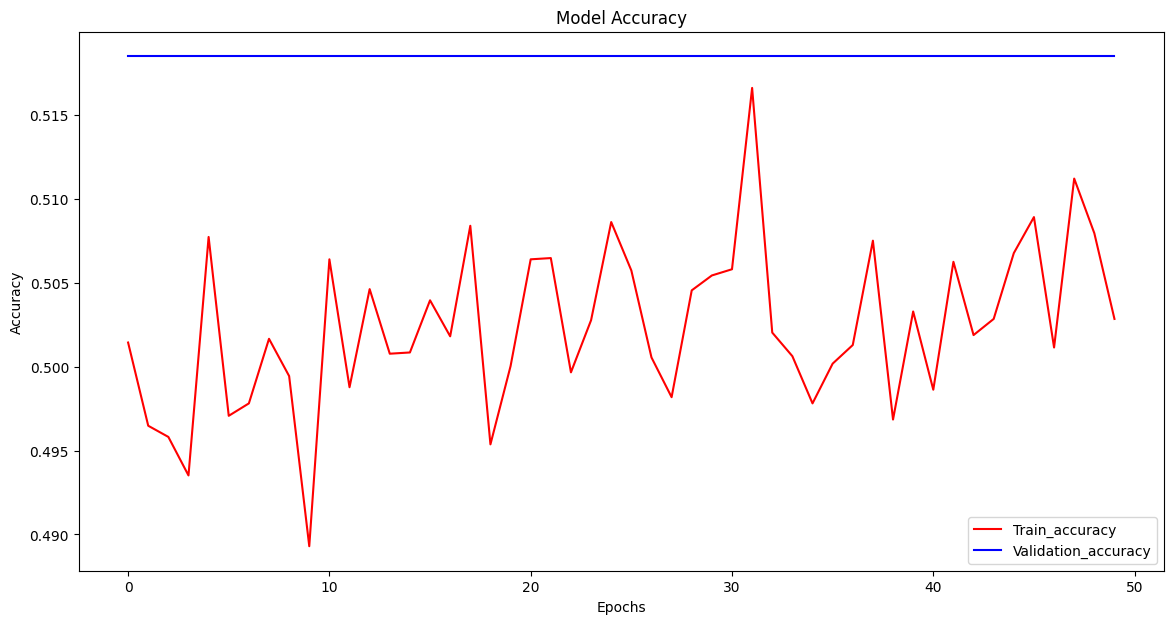

In [25]:
#accuracy chart 
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r', label="Train_accuracy")
plt.plot(epochs,val_acc,'b', label="Validation_accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.show()